# Stellar Interpretation for Meteoritic data and PLotting (for Everyone) - SIMPLE 

In [1]:
import sys

import os
import re
import numpy as np
import matplotlib as mpl

import matplotlib.pyplot as plt
#import data_dirlib.patches as patch
import time as t
import more_itertools as mit

import h5py
import csv

import datetime
#from datetime import datetime
import ast

# check if the abundance file is there. If it is not available, we load the models and we need more packages.
# or I just remove it and I go ahead with the typical mode
# if check_file is true, there is no need to load all the models again

!rm selected_abundances_data.txt
check_data_file = os.path.isfile('selected_abundances_data.txt')

#if check_data_file == False:
#    sys.path.append('/home/marco/work/NuGridPy')
#    from nugridpy import utils as u
#    from nugridpy import nugridse as mp
from nugridpy import utils as u
from nugridpy import nugridse as mp

# import function repository
%load_ext autoreload
%autoreload 2
from repo_functions import *

#%matplotlib nbagg
%pylab ipympl


# data stored
#data_dir="/data/nugrid/data/chetec-infra_models/"
data_dir="/data/nugrid_data/chetec-infra_models/"


Populating the interactive namespace from numpy and matplotlib


In [2]:
if check_data_file == False:
    # loading Ritter+18 model
    fol2mod = data_dir+'R18/'
    # load instances of models
    # 15Msun
    pt_15 = mp.se(fol2mod,'M15.0Z2.0e-02.Ma.0020601.out.h5',rewrite=True)
    cyc_15 = pt_15.se.cycles[-1]
    #pt_15.se.get('temperature')
    t9_cyc_15  = pt_15.se.get(cyc_15,'temperature')
    mass_15 = pt_15.se.get(cyc_15,'mass')
    # 20Msun
    pt_20 = mp.se(fol2mod,'M20.0Z2.0e-02.Ma.0021101.out.h5',rewrite=True)
    cyc_20 = pt_20.se.cycles[-1]
    #pt_20.se.get('temperature')
    t9_cyc_20  = pt_20.se.get(cyc_20,'temperature')
    mass_20 = pt_20.se.get(cyc_20,'mass')
    # 25Msun
    pt_25 = mp.se(fol2mod,'M25.0Z2.0e-02.Ma.0023601.out.h5',rewrite=True)
    cyc_25 = pt_25.se.cycles[-1]
    #pt_25.se.get('temperature')
    t9_cyc_25  = pt_25.se.get(cyc_25,'temperature')
    mass_25 = pt_25.se.get(cyc_25,'mass')
    
    # loading AGB models
    # test case, M=3Msun, Z=0.03, Battino et al., getting only the last surf file
    pt_3 = mp.se(data_dir+'agb_surf_m3z2m3/','96101.surf.h5',rewrite=True)


In [3]:
if check_data_file == False:
    # loading Pignatari+16 model
    fol2mod = data_dir+'P16/'
    # load instances of models
    # 15Msun
    P16_15 = mp.se(fol2mod,'M15.0',rewrite=True)
    cyc_P16_15 = P16_15.se.cycles[-1]
    #pt_15.se.get('temperature')
    t9_cyc_P16_15  = P16_15.se.get(cyc_P16_15,'temperature')
    mass_P16_15 = P16_15.se.get(cyc_P16_15,'mass')
    # 20Msun
    P16_20 = mp.se(fol2mod,'M20.0',rewrite=True)
    cyc_P16_20 = P16_20.se.cycles[-1]
    #pt_20.se.get('temperature')
    t9_cyc_P16_20  = P16_20.se.get(cyc_P16_20,'temperature')
    mass_P16_20 = P16_20.se.get(cyc_P16_20,'mass')
    # 25Msun
    P16_25 = mp.se(fol2mod,'M25.0',rewrite=True)
    cyc_P16_25 = P16_25.se.cycles[-1]
    #pt_25.se.get('temperature')
    t9_cyc_P16_25  = P16_25.se.get(cyc_P16_25,'temperature')
    mass_P16_25 = P16_25.se.get(cyc_P16_25,'mass')

In [4]:
if check_data_file == False:
    # Loading Lawson+22 - 1 peformance upgrade
    dir_law = data_dir+'LAW22/'
    models_list = ['M15s_run15f1_216M1.3bgl_mp.txt','M20s_run20f1_300M1.56jl_mp.txt','M25s_run25f1_280M1.83rrl_mp.txt']
    num_species = 5209
    
    start_time = t.time()
    numpart_all = []; massinc_all = []
    anum_all = []; znum_all = []; x_all = []
    iso_name_all = []; num_of_part_all = []
    for i in models_list:
        mass, numpart, number_of_parts, a, z, x, iso = load_lawson22(dir_law+i,num_species)
        massinc_all.append(mass); num_of_part_all.append(number_of_parts); numpart_all.append(numpart) 
        anum_all.append(a); znum_all.append(z); x_all.append(x); iso_name_all.append(iso)
    
    print_time("done with Lawson",start_time)

In [5]:
if check_data_file == False:
    # dir where Sieverdin models are located
    dir_sie = data_dir+'SIE18/'
    
    file_sie_all = ["s15_data.hdf5","s20_data.hdf5","s25_data.hdf5"]

In [6]:
if check_data_file == False:
    # Rauscher - 1 peformance upgrade
    dir_rau = data_dir+'R02/'
    
    #models_rau = ['s15a28c.expl_yield']
    models_rau = ['s15a28c.expl_yield','s20a28n.expl_yield','s25a28d.expl_yield']
    
    start_time = t.time()
    
    rau_mass = []; rau_isos = []; rau_x = []
    for i in range(len(models_rau)):
        filename = dir_rau+models_rau[i]
        print(filename)
        f = open(filename,'r')
        head = f.readline(); isos_dum = head.split()[5:] # getting isotopes, not first header names
        dum_a = [re.findall('\d+', ik)[0] for ik in isos_dum] # getting the A from isotope name
        dum_el = [re.sub(r'[0-9]+', '', ik) for ik in isos_dum] # getting the element name from the isotope name
        dum_new_iso = [dum_el[ik].capitalize()+'-'+dum_a[ik] for ik in range(len(isos_dum))]
        rau_isos.append(dum_new_iso) # isotope name that we can use around, just neutron name is different, but not care
        #
        data = f.readlines()[:-2]                        # getting the all data, excepting the last two lines
                                              # done reading, just closing the file now
        #
        dum = [float(ii.split()[1])/1.989e+33 for ii in data]; rau_mass.append(dum) # converting in Msun too.
        x_dum = []
        
        
        data = [row.split()[3:] for row in data]
        #
        x_dum = np.transpose(data); x_dum = np.asfarray(x_dum,float)
        print_time("x transpose and done",start_time)
        rau_x.append(x_dum)


In [7]:
# abundances in mass fraction of all the isotopes in the network. 
# unstable nuclei are allowed to decay only within the first 2.5e4 s
# mmmzvvv.dif_iso_nod  received Jan 2023
# 013a000.dif_iso_nod  020a000.dif_iso_nod
# 015a000.dif_iso_nod  025a000.dif_iso_nod

if check_data_file == False:
    # data from LC18
    dir_lc18 = data_dir+'LC18/'

    models_lc18 = ['015a000.dif_iso_nod','020a000.dif_iso_nod','025a000.dif_iso_nod']
    
    skip_heavy_ = 43 # usedd to skip final ye and spooky abundances (see below)
    
    start_time = t.time()
    
    lc18_mass = []; lc18_isos = []; lc18_x = []
    for i in range(len(models_lc18)):
        filename = dir_lc18+models_lc18[i]
        print(filename)
        f = open(filename,'r')
        # getting isotopes, not first header names, and final ye and spooky abundances (group of isolated isotopes, 
        # probably sorted with artificial reactions handling mass conservation or sink particles approach)
        head = f.readline(); isos_dum = head.split()[4:-skip_heavy_] 
        # correcting names to get H1 (and the crazy P and A)
        isos_dum[0]=isos_dum[0]+'1'; isos_dum[1]=isos_dum[1]+'1'; isos_dum[6]=isos_dum[6]+'1' 
        dum_a = [re.findall('\d+', ik)[0] for ik in isos_dum] # getting the A from isotope name
        dum_el = [re.sub(r'[0-9]+', '', ik) for ik in isos_dum] # getting the element name from the isotope name
        dum_new_iso = [dum_el[ik].capitalize()+'-'+dum_a[ik] for ik in range(len(isos_dum))]
        lc18_isos.append(dum_new_iso) # isotope name that we can use around, just neutron name is different, but not care
        #
        data = f.readlines()[:-1]             # getting the all data, excepting the last fake line (bounch of zeros)
                                              # done reading, just closing the file now
        #
        dum = [float(ii.split()[0]) for ii in data]; lc18_mass.append(dum) # converting in Msun too.
        x_dum = []
        
        
        data = [row.split()[4:-skip_heavy_] for row in data]
        #
        x_dum = np.transpose(data); x_dum = np.asfarray(x_dum,float)
        print_time("x transpose and done",start_time)
        lc18_x.append(x_dum)


In [8]:
# getting the solar for SIMPLE
# this is here just for give_ratios. Once we will use only give_ratios_gm, this line will not be needed
s_abu, s_iso_new = load_solar()

# load isotopic masses from isopy file (csv), based on Wang et al. 2017
with open('isotope_mass_W17.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, skipinitialspace=True)
    next(reader); next(reader)
    dum = []
    for row in reader:
        dum.append(row)
iso_dum = dum[0]; iso_masses = np.array([float(i) for i in dum[1]])

# here below some simple way to build the isotope name with the same structure of the models.
name_iso_masses = [re.sub(r'[0-9]+', '', i)+'-'+re.findall(r'\d+', i)[0] for i in iso_dum]

In [9]:
# from development made by Georgy... this is no good for now... here would work only for Fe and Ni
# why do I need this isotope_standard without using solar? Is this attached to a given experiment?
# If this is the case, then this should go in the input deck. 
# load isotope standard data

f = open('isotope_standards.txt', 'r')
standard_data = f.readlines()[1:]
f.close()

std_iso_temp = []
std_ratio = []

for i in standard_data:
    std_iso_temp.append(i[0:6].strip())
    std_ratio.append(float(i[9:]))
    
std_iso_temp = np.array(std_iso_temp)
std_ratio = np.array(std_ratio)

# converted here below to the same SIMPLE shape
std_iso = [i[:2].strip()+'-'+i[2:].strip() for i in std_iso_temp]
print(std_iso)
print(std_ratio)

['Fe-54', 'Fe-56', 'Fe-57', 'Fe-58', 'Ni-58', 'Ni-60', 'Ni-61', 'Ni-62', 'Ni-64']
[0.062669  1.        0.023261  0.0031132 2.596061  1.        0.043469
 0.1386    0.035295 ]


In [10]:
#read in the txt file for the required data
# MP: I think here should also go iso_list and e_label. Any reason why this is not the case?

with open('models.txt', 'r') as f:
    file = f.readlines()

reqmass = int(file[0].strip()) #required solar mass
rmodels = file[1].lower().split(',') ; rmodels = [i.strip() for i in rmodels] #required models
abu_elements=list(file[2].split(',')) ; abu_elements = [i.strip() for i in abu_elements]
abu_name=str(file[3].strip())

# delta, mu, etc for the isotopes you want for element 1
iso_up_plot=list(file[5].split(',')) ; iso_up_plot = [i.strip() for i in iso_up_plot] #stable isotopes
ratio1_elements=list(file[6].strip().split(',')); ratio1_elements = [i.strip() for i in ratio1_elements] #required isotopes
iso_down_plot = [file[7].strip()] * len(iso_up_plot)
iso_norm_mu_and_eps = [file[8].strip()] * len(iso_up_plot) # this is the isotope used for the double normalization
iso_norm_slope = file[9].strip() # isotope used for the normalization done on the epsilon or mu to get the slope
ratio1_name=str(file[10].strip())

for ln, line in enumerate(file):
    if 'iso_deck_start' in line:
        start_i = ln+1
    elif 'iso_deck_end' in line:
        end_i = ln
        
iso_list = []
e_label = []
isotopes = file[start_i:end_i]
for isotope in isotopes:
    parts = isotope.split('/')
    dum = parts[0].split(','); dum = [i.strip() for i in dum]; iso_list.append(dum)
    e_label.append(parts[1].strip())



In [11]:
# alright. The previous cells just need to be run once. Once you got instances for all the models,
# you are good to go with the analysis. 
# what of the three models I want for each flavour?
# this is the deck for the models


if reqmass not in [15, 20, 25]:
    print("Error. You can choose only 15, 20, 25 solar mass")
    exit()

if reqmass == 15:
    ind_ = 0
elif reqmass == 20:
    ind_ = 1
elif reqmass == 25:
    ind_ = 2


if check_data_file == False:
    models = {
        15: {
            "pt_exp": pt_15,
            "cyc_exp": cyc_15,
            "t9_cyc": t9_cyc_15,
            "mass": mass_15,
            "p16_exp": P16_15,
            "p16_cyc": cyc_P16_15,
            "p16_t9_cyc": t9_cyc_P16_15,
            "p16_mass": mass_P16_15
        },
        20: {
            "pt_exp": pt_20,
            "cyc_exp": cyc_20,
            "t9_cyc": t9_cyc_20,
            "mass": mass_20,
            "p16_exp": P16_20,
            "p16_cyc": cyc_P16_20,
            "p16_t9_cyc": t9_cyc_P16_20,
            "p16_mass": mass_P16_20
        },
        25: {
            "pt_exp": pt_25,
            "cyc_exp": cyc_25,
            "t9_cyc": t9_cyc_25,
            "mass": mass_25,
            "p16_exp": P16_25,
            "p16_cyc": cyc_P16_25,
            "p16_t9_cyc": t9_cyc_P16_25,
            "p16_mass": mass_P16_25
        }
    }

    # Ritter+18
    pt_exp = models[reqmass]["pt_exp"]
    cyc_exp = models[reqmass]["cyc_exp"]
    t9_cyc = models[reqmass]["t9_cyc"]
    mass = models[reqmass]["mass"]
    
    # Pignatari+16
    p16_exp = models[reqmass]["p16_exp"]
    p16_cyc = models[reqmass]["p16_cyc"]
    p16_t9_cyc = models[reqmass]["p16_t9_cyc"]
    p16_mass = models[reqmass]["p16_mass"]
    
    # lawson+22 # 0=15Msun; 1=20Msun; 2=25Msun
    numpart = numpart_all[ind_]; mass_inc = massinc_all[ind_]
    anum = anum_all[ind_]; znum = znum_all[ind_]; x = x_all[ind_]
    iso_name = iso_name_all[ind_]; num_of_part = num_of_part_all[ind_]
    
    # sieverdin et al # 0=15Msun; 1=20Msun; 2=25Msun
    file_sie = file_sie_all[ind_]
    
    # Rauscher+02 # 0=15Msun; 1=20Msun; 2=25Msun
    rau_mass_1 = rau_mass[ind_]; rau_x_1 = rau_x[ind_]
    rau_isos_1 = rau_isos[ind_]
    
    # Limongi & Chieffi 2018 # 0=15Msun; 1=20Msun; 2=25Msun
    lc18_mass_1 = lc18_mass[ind_]; lc18_x_1 = lc18_x[ind_]
    lc18_isos_1 = lc18_isos[ind_]

In [12]:
if check_data_file == False:
    # Battino et al. -test case AGB
    sparsity_surf = 100
    
    pt_agb  = pt_3
    time_ev = pt_3.se.ages[0::sparsity_surf]
    print(len(time_ev))

In [13]:
if check_data_file == False:
    # getting mass and abundances for single isotopes, or single isotopes + radiogenic "by hand", 
    # or elements by adding isotopes    
    
    # ritter+18
    cyc_ = cyc_exp 
    mass = pt_exp.se.get(cyc_,'mass')
    
    # not loading the full arrays all the time, just once, and transposing around
    dum_ab = np.transpose(pt_exp.se.get(cyc_,'iso_massf')); dum_iso = pt_exp.se.isotopes
    
    e_abund = []
    for i in iso_list:
        #iso_abund = 0.; tmp = [pt_exp.se.get(cyc_,'iso_massf',ii) for ii in i]
        iso_abund = 0.; tmp = func_species_deck('rit18',dum_ab,dum_iso,i)
        iso_abund = [np.sum(tmp,axis = 0)][0]
        e_abund.append(iso_abund)
        
    e_abund = np.array(e_abund)
    
    # pignatari+16
    cyc_ = p16_cyc 
    p16_mass = p16_exp.se.get(cyc_,'mass')
    
    # not loading the full arrays all the time, just once, and transposing around
    dum_ab = np.transpose(p16_exp.se.get(cyc_,'iso_massf')); dum_iso = p16_exp.se.isotopes
    
    p16_abund = []
    for i in iso_list:
        #iso_abund = 0.; tmp = [pt_exp.se.get(cyc_,'iso_massf',ii) for ii in i]
        iso_abund = 0.; tmp = func_species_deck('p16',dum_ab,dum_iso,i)
        iso_abund = [np.sum(tmp,axis = 0)][0]
        p16_abund.append(iso_abund)
        
    p16_abund = np.array(p16_abund)
    
    
    # Lawson+22
    y = []
    for j in iso_list:
        tmp = []
        for jj in j:
            dum = [x[i][iso_name[i].index(jj)] for i in range(num_of_part)]
            tmp.append(dum)
        iso_abund = [np.sum(tmp,axis = 0)][0]
        y.append(iso_abund)
    
    y = np.array(y)
        
    # Sieverdin+
    flat = [x for sublist in iso_list for x in sublist]
    iso_list_sie = [s.replace("-", "").lower() for s in flat]
    #print(iso_list_sie)
    results=get_profiles(dir_sie+file_sie,isotopes=iso_list_sie,decayed=False)    
    
    sie_abund = []
    for i in iso_list:
        iso_abund = 0.; tmp = [results["post-sn"][iso.replace("-", "").lower()] for iso in i]
        iso_abund = [np.sum(tmp,axis = 0)][0]
        sie_abund.append(iso_abund)
    
    sie_abund = np.array(sie_abund)
        
        
    mass_sie = results["post-sn"]["mr"] # mass
    
    
    # Rauscher+2002
    rau_y = []
    for j in iso_list:
        #tmp = [rau_x_1[rau_isos_1.index(jj)] for jj in j]
        tmp = func_species_deck('rau02',rau_x_1,rau_isos_1,j) 
        #print(tmp)
        rau_iso_abund = [np.sum(tmp,axis = 0)][0]
        rau_y.append(rau_iso_abund)
    
    rau_y = np.array(rau_y)
        
    # LC+2018
    lc18_y = []
    for j in iso_list:
        #tmp = [lc18_x_1[lc18_isos_1.index(jj)] for jj in j]
        tmp = func_species_deck('lc18',lc18_x_1,lc18_isos_1,j)
        #print(tmp)
        lc18_iso_abund = [np.sum(tmp,axis = 0)][0]
        lc18_y.append(lc18_iso_abund)
    
    lc18_y = np.array(lc18_y)

In [14]:
if check_data_file == False:
    # AGB surf test
    # not loading the full arrays all the time, just once, and transposing around
    #dum_ab = np.transpose(pt_3.se.get('iso_massf')[0::sparsity_surf]); dum_iso = pt_3.se.isotopes
    #dum_ab = [pt_3.se.get(int(dum_cyc),'iso_massf') for dum_cyc in pt_3.se.cycles[0::sparsity_surf]]
    #
    # oh no... issue in data written in surf files, some as arrays some as list(array(...)). Talk with Umberto, check
    # mppnp revision (an oldy??) and dealing with allocatable arrays. So, just grabbing the last one, bah... 
    #dum_ab = pt_3.se.get('iso_massf')[-1]
    ccc = pt_agb.se.cycles[-1] ; dum_ab = pt_agb.se.get(ccc,'iso_massf')
    dum_ab = np.array(dum_ab)
    # ! *** !
    # this is done to create from the single surf file a 2d array. This is temporary, since in give_ratio_gm there is a check
    # assuming that there is more than 1 mass coordinate given in dilution/precision setup
    dum_ab = np.stack((dum_ab,dum_ab), axis=0)
    #
    dum_iso = pt_agb.se.isotopes
    
    agb_abund = []
    for i in iso_list:
        #iso_abund = 0.; tmp = [pt_3.se.get(cyc_,'iso_massf',ii) for ii in i]
        iso_abund = 0.; tmp = func_species_deck('bat20',np.transpose(dum_ab),dum_iso,i)
        iso_abund = [np.sum(tmp,axis = 0)][0]
        agb_abund.append(iso_abund)
    agb_abund = np.array(agb_abund)


In [15]:
if check_data_file == False:
    # preparation for light mode version: write all abundances in an external file:
    # notice the crazy array of lists to list... this is not needed, just to check to be able to write and read
    # multiple times for testing, writing lists as strings and read arrays from strings in the cell below.
    
    data_pot= open('selected_abundances_data.txt','w')
    
    data_pot.write(datetime.date.today().strftime('%Y-%m-%d %H:%M:%S')+' file with selected species - light mode Marco'+'\n')
    # list of species to check and labels
    data_pot.write(str(iso_list)+' \n') # isotope list
    data_pot.write(str(np.array(list(e_label)).tolist())+' \n')  # list for labels in plots
    # rau02
    data_pot.write(str(list(rau_mass_1))+' \n')  # list of Rau02 mass coordinates
    data_pot.write(str(np.array(list(rau_y)).tolist())+' \n')  # list of Rau02 abundances for given mass coordinates
    # rit18
    data_pot.write(str(np.array(list(mass)).tolist())+' \n')  # list of Rit18 mass coordinates
    data_pot.write(str(np.array(list(e_abund)).tolist())+' \n')  # list of Rit18 abundances for given mass coordinates
    # let's add some pain here... the temperature array to check the masscut in the processed ejecta
    data_pot.write(str(np.array(list(t9_cyc)).tolist())+' \n')
    # pgn16
    data_pot.write(str(np.array(list(p16_mass)).tolist())+' \n')  # list of Pgn16 mass coordinates
    data_pot.write(str(np.array(list(p16_abund)).tolist())+' \n')  # list of Pgn16 abundances for given mass coordinates
    # let's add some pain here... the temperature coordinate to check the processed ejecta
    data_pot.write(str(np.array(list(p16_t9_cyc)).tolist())+' \n')
    # law22
    data_pot.write(str(np.array(list(mass_inc)).tolist())+' \n')  # list of Law22 mass coordinates
    data_pot.write(str(np.array(list(y)).tolist())+' \n')  # list of Law22 abundances for given mass coordinates
    # sie18
    data_pot.write(str(np.array(list(mass_sie)).tolist())+' \n')  # list of Sie18 mass coordinates
    data_pot.write(str(np.array(list(sie_abund)).tolist())+' \n')  # list of Sie18 abundances for given mass coordinates
    # LC18
    data_pot.write(str(np.array(list(lc18_mass_1)).tolist())+' \n')  # list of LC18 mass coordinates
    data_pot.write(str(np.array(list(lc18_y)).tolist())+' \n')  # list of LC18 abundances for given mass coordinates
    # bat20
    data_pot.write(str(np.array(list(agb_abund)).tolist())+' \n')  # list of Bat20 abundances for the surface (final step)
    
    
    
    data_pot.close()
    

In [16]:
# and read now.... 

data_pot = open('selected_abundances_data.txt','r')

data_pot.readline()
data  = data_pot.readlines()

data_pot.close()

# .... and rebuild the data back
# list of species to check and labels
iso_list = ast.literal_eval(data[0])
e_label  = ast.literal_eval(data[1])
# rau02
rau_mass_1 = np.array(ast.literal_eval(data[2])); rau_y = np.array(ast.literal_eval(data[3]))
# rit18
mass = np.array(ast.literal_eval(data[4])); e_abund = np.array(ast.literal_eval(data[5]))
t9_cyc = np.array(ast.literal_eval(data[6]))
# pgn16
p16_mass = np.array(ast.literal_eval(data[7])); p16_abund = np.array(ast.literal_eval(data[8]))
p16_t9_cyc = np.array(ast.literal_eval(data[9]))
# law22
mass_inc = np.array(ast.literal_eval(data[10])); y = np.array(ast.literal_eval(data[11]))
# sie18
mass_sie = np.array(ast.literal_eval(data[12])); sie_abund = np.array(ast.literal_eval(data[13]))
# LC18
lc18_mass_1 = np.array(ast.literal_eval(data[14])); lc18_y = np.array(ast.literal_eval(data[15]))
# Bat20
agb_abund = np.array(ast.literal_eval(data[16]))


In [17]:
# delta, mu, etc for the isotopes you want for element 1
# THIS PART IS PROVIDED BY GABOR FILE NOW.
#iso_up_plot         = ['Ni-58','Ni-60','Ni-60*','Ni-61*','Ni-62','Ni-64','Ni-64*']
#iso_down_plot       = ['Ni-58']*len(iso_up_plot)
## these isotopes below should be included in iso_up_plot. 
## Check if they could be other isotopes, e.g., from other elements?
##iso_norm_mu_and_eps = 'Ni-58' # this is the isotope used for the double normalization
#iso_norm_mu_and_eps = ['Ni-61*']*len(iso_up_plot) # this is the isotope used for the double normalization
#iso_norm_slope      = 'Ni-62' # isotope used for the normalization done on the epsilon or mu to get the slope

# what function to use to calculate ratios
func_ratio_dum = give_ratios_gm #give_ratios # give_ratios_gm
# dilution : to be checked, does not work well
# linear : seems to be close to give_ratios
# better_linear : same result as give_ratios
# std_linear : some differences, but close enough (?)
method_dum = 'dilution' #'dilution' #'std_linear' # 'linear' # 'better_linear'
iteration_dum = 'precision'  # 'largest_offset' 'precision'

# getting the abundance ratio and everything for the models   
data_dump = \
func_ratio_dum(e_abund, e_label, iso_masses, name_iso_masses, iso_up_plot, iso_down_plot, iso_norm_mu_and_eps, iso_norm_slope\
              , solar_ref_for_ratios = 'iniab2.0E-02GN93.ppn'\
               , approximation_method = method_dum, iteration_method = iteration_dum)
rit_deltapmil = data_dump[0]; rit_slope = data_dump[1] ; rit_mind_slope = data_dump[2]

data_dump = \
func_ratio_dum(p16_abund, e_label, iso_masses, name_iso_masses, iso_up_plot, iso_down_plot, iso_norm_mu_and_eps, iso_norm_slope\
              , solar_ref_for_ratios = 'iniab2.0E-02GN93_Lo03.ppn'\
              , approximation_method = method_dum, iteration_method = iteration_dum)
p16_deltapmil = data_dump[0]; p16_slope = data_dump[1] ; p16_mind_slope = data_dump[2]

data_dump = \
func_ratio_dum(y, e_label, iso_masses, name_iso_masses, iso_up_plot, iso_down_plot, iso_norm_mu_and_eps, iso_norm_slope\
              , solar_ref_for_ratios = 'iniab2.0E-02GN93_Lo03.ppn'\
              , approximation_method = method_dum, iteration_method = iteration_dum)
law_deltapmil = data_dump[0]; law_slope = data_dump[1] ; law_mind_slope = data_dump[2]

data_dump = \
func_ratio_dum(sie_abund, e_label, iso_masses, name_iso_masses, iso_up_plot, iso_down_plot,iso_norm_mu_and_eps, iso_norm_slope\
              , solar_ref_for_ratios = 'iniab1.3E-02Lo03_Lo03_merged.ppn'\
              , approximation_method = method_dum, iteration_method = iteration_dum)
sie_deltapmil = data_dump[0]; sie_slope = data_dump[1] ; sie_mind_slope = data_dump[2]

data_dump = \
func_ratio_dum(rau_y, e_label, iso_masses, name_iso_masses, iso_up_plot, iso_down_plot, iso_norm_mu_and_eps, iso_norm_slope\
              , solar_ref_for_ratios = 'iniab1.9E-02AG89_AG89.ppn'\
              , approximation_method = method_dum, iteration_method = iteration_dum)
rau_deltapmil = data_dump[0]; rau_slope = data_dump[1] ; rau_mind_slope = data_dump[2]

data_dump = \
func_ratio_dum(lc18_y, e_label,iso_masses, name_iso_masses, iso_up_plot, iso_down_plot, iso_norm_mu_and_eps, iso_norm_slope\
              , solar_ref_for_ratios = 'iniab1.3E-02As09_As09_merged.ppn'\
              , approximation_method = method_dum, iteration_method = iteration_dum)
lc18_deltapmil = data_dump[0]; lc18_slope = data_dump[1] ; lc18_mind_slope = data_dump[2]

# test AGB -Battino+
# getting the abundance ratio and everything for the models   
data_dump = \
func_ratio_dum(agb_abund, e_label, iso_masses, name_iso_masses, iso_up_plot, iso_down_plot, iso_norm_mu_and_eps, iso_norm_slope\
              , solar_ref_for_ratios = 'iniab2.0E-02GN93_Lo03.ppn'\
              , approximation_method = method_dum, iteration_method = iteration_dum)
bat_deltapmil = data_dump[0]; bat_slope = data_dump[1] ; bat_mind_slope = data_dump[2]


#print(isinstance(rit_deltapmil,np.ndarray))
#print(isinstance(rit_deltapmil,list))

### delta, mu, etc for the isotopes you want for element 2
###
#iso_up_plot2        = ['Fe-54','Fe-57','Fe-58']
#iso_down_plot2       = ['Fe-56']*len(iso_up_plot2)
## these isotopes below should be included in iso_up_plot. 
## Check if they could be other isotopes, e.g., from other elements?
#iso_norm_mu_and_eps2 = ['Fe-57']*len(iso_up_plot2) # this is the isotope used for the double normalization
#iso_norm_slope2      = 'Ni-58' # isotope used for the normalization done on the epsilon or mu to get the slope
#
### getting the abundance ratio and everything for the models   
#rit_deltapmil2, rit_slope2 = \
#give_ratios(e_abund, iso_up_plot2, iso_down_plot2, iso_norm_mu_and_eps2, iso_norm_slope2)
#p16_deltapmil2, p16_slope2 = \
#give_ratios(p16_abund, iso_up_plot2, iso_down_plot2, iso_norm_mu_and_eps2, iso_norm_slope2)
#law_deltapmil2, law_slope2 = \
#give_ratios(y, iso_up_plot2, iso_down_plot2, iso_norm_mu_and_eps2, iso_norm_slope2)
#sie_deltapmil2, sie_slope2 = \
#give_ratios(sie_abund, iso_up_plot2, iso_down_plot2,iso_norm_mu_and_eps2, iso_norm_slope2)
#rau_deltapmil2, rau_slope2 = \
#give_ratios(rau_y, iso_up_plot2, iso_down_plot2, iso_norm_mu_and_eps2, iso_norm_slope2)
#lc18_deltapmil2, lc18_slope2 = \
#give_ratios(lc18_y, iso_up_plot2, iso_down_plot2, iso_norm_mu_and_eps2, iso_norm_slope2)
#

# getting the abundance ratio and everything for the models
#if len(file)>13:
#    rit_deltapmil2, rit_slope2 = \
#    give_ratios(e_abund, iso_up_plot2, iso_down_plot2, iso_norm_mu_and_eps2, iso_norm_slope2\
#              , approximation_method = method_dum)
#    p16_deltapmil2, p16_slope2 = \
#    give_ratios(p16_abund, iso_up_plot2, iso_down_plot2, iso_norm_mu_and_eps2, iso_norm_slope2\
#              , approximation_method = method_dum)
#    law_deltapmil2, law_slope2 = \
#    give_ratios(y, iso_up_plot2, iso_down_plot2, iso_norm_mu_and_eps2, iso_norm_slope2\
#              , approximation_method = method_dum)
#    sie_deltapmil2, sie_slope2 = \
#    give_ratios(sie_abund, iso_up_plot2, iso_down_plot2,iso_norm_mu_and_eps2, iso_norm_slope2\
#              , approximation_method = method_dum)
#    rau_deltapmil2, rau_slope2 = \
#    give_ratios(rau_y, iso_up_plot2, iso_down_plot2, iso_norm_mu_and_eps2, iso_norm_slope2\
#              , approximation_method = method_dum)
#    lc18_deltapmil2, lc18_slope2 = \
#    give_ratios(lc18_y, iso_up_plot2, iso_down_plot2, iso_norm_mu_and_eps2, iso_norm_slope2\
#              , approximation_method = method_dum)

step 1 dilution_factor = 1
step 2 dilution_factor = 0.1
step 3 dilution_factor = 0.010000000000000002
step 4 dilution_factor = 0.0010000000000000002
step 5 dilution_factor = 0.00010000000000000003
step 6 dilution_factor = 1.0000000000000004e-05
step 7 dilution_factor = 1.0000000000000004e-06
step 8 dilution_factor = 1.0000000000000005e-07
step 9 dilution_factor = 1.0000000000000005e-08
step 10 dilution_factor = 1.0000000000000005e-09
step 11 dilution_factor = 1.0000000000000006e-10
step 12 dilution_factor = 1.0000000000000006e-11
step 13 dilution_factor = 1.0000000000000006e-12
dilution_factor too small, max slope_diff = 1.97568811307998 
took 13 iterations, final dilution_factor 1.0000000000000008e-14
step 1 dilution_factor = 1
step 2 dilution_factor = 0.1
step 3 dilution_factor = 0.010000000000000002
step 4 dilution_factor = 0.0010000000000000002
step 5 dilution_factor = 0.00010000000000000003
step 6 dilution_factor = 1.0000000000000004e-05
step 7 dilution_factor = 1.0000000000000004

/user/scratch14_wendi3/marco/chetec-infra_WP9/repo_functions.py:398: RuntimeWarning: divide by zero encountered in true_divide
  slope = np.array(rho_mind/rho_mind_slope + 1e-200)
/user/scratch14_wendi3/marco/chetec-infra_WP9/repo_functions.py:398: RuntimeWarning: invalid value encountered in true_divide
  slope = np.array(rho_mind/rho_mind_slope + 1e-200)


In [18]:
#print('precision')
#print(len(sie_abund),len(sie_abund[0]))
#print(len(e_abund),len(e_abund[0]))
#print(len(p16_abund),len(p16_abund[0]))
#print(len(y),len(y[0]))
#print(len(rau_y),len(rau_y[0]))
#print(len(lc18_y),len(lc18_y[0]))
###
#print(len(agb_abund),agb_abund)
#print(bat_slope)
#print(lc18_slope[1])


# Compile data

Here all the loaded data is put into a single dictionary. This should be easy to traverse as its the same keys to get everything.

The structure is:
``all_models[model_name][model_mass][data_type]``

the data types are:
- ``masscoord`` - An array with the mass coordinates
- ``abu`` - A dictionary containing the abundances. Mapped to e_label
- ``slope`` - A dictionary containing the slopes. Mapped to iso_up_plot/iso_norm_slope

In [19]:
# from the part here on, this new dictionary could be used for the figures. Once implemented, it should generate the same figures as before

slope_isotopes = tuple(f"{n}/{iso_norm_slope}" for n in iso_up_plot)
abu_isotopes = e_label

r18_ind_tmp = np.where(t9_cyc > 1.1e-9)[0][0]
p16_ind_tmp = np.where(p16_t9_cyc < 1.1e-10)[0][0]

label_models = ['Ri18', 'Pi16', 'La22', 'Si18', 'LC18', 'Ra02']
model_inputs=[(label_models[0], mass[r18_ind_tmp:], tuple(a[r18_ind_tmp:] for a in e_abund), tuple(a[r18_ind_tmp:] for a in rit_slope), \
               #tuple(a[r18_ind_tmp:] for a in rit_mind_slope), 
               tuple(a[r18_ind_tmp:] for a in rit_deltapmil)),
              (label_models[1], p16_mass[p16_ind_tmp:], tuple(a[p16_ind_tmp:] for a in p16_abund), tuple(a[p16_ind_tmp:] for a in p16_slope), \
              #tuple(a[p16_ind_tmp:] for a in p16_mind_slope),
               tuple(a[p16_ind_tmp:] for a in p16_deltapmil)),
              (label_models[2], mass_inc, y, law_slope, \
               #law_mind_slope, 
               law_deltapmil),
              (label_models[3],  mass_sie[:], sie_abund, sie_slope, \
               #sie_mind_slope, 
               sie_deltapmil),
              (label_models[4], lc18_mass_1, lc18_y, lc18_slope, \
               #lc18_mind_slope, 
               lc18_deltapmil),
              (label_models[5], rau_mass_1, rau_y, rau_slope, \
               #rau_mind_slope, 
               rau_deltapmil)]


all_models = {}
for name, masscoord, abu, slope, ratio_minus_1 in model_inputs:
    all_models[name] = {reqmass: {}}
    all_models[name][reqmass]['masscoord'] = masscoord
    all_models[name][reqmass]['abu'] = {iso: abu[i] for i, iso in enumerate(abu_isotopes)}
    all_models[name][reqmass]['slope'] = {iso: slope[i] for i, iso in enumerate(slope_isotopes)}
    #all_models[name][reqmass]['slope_sign'] = {iso: slope_sign for i, iso in enumerate(slope_isotopes)}
    all_models[name][reqmass]['isoratio_minus_1'] = {iso: ratio_minus_1[i] for i, iso in enumerate(slope_isotopes)}
    # We could also add the corresponding solar value here so that its easy to get

In [20]:
#print(len(all_models['Rauscher02'][reqmass]['masscoord']))
##print(len(all_models['Rauscher02'][reqmass]['slope']))
#print(len(all_models['Rauscher02'][reqmass]['slope']['Zn-68*/Zn-70*']))


In [21]:
# when 2 elements are involved...
#ref_EL1_el2 = 'Ni-61'
#ref_el1_EL2 = 'Fe-56'

# correcting quantities in case slope or mu are compared against different elements
# this should work for whatever correct combination:
# rit* with e_abund; law* with y and sie* with sie_abund
# ...
#rit_dsm_corr = func_el_corr(rit_dsm, e_abund, ref_EL1_el2, ref_el1_EL2, mode=1)
#rit_dsm_corr = func_el_corr(rit_slope2, e_abund, ref_EL1_el2, ref_el1_EL2, mode=2,\
#                            file_fractionation='sandbox_element_correction.txt',what_in_file='O-rich_Isaac')

In [22]:
# test solar vs standard-reference-material
# all of those are ratios, all relatives to Ni60, dimensionless
#srm5861 = 2.596061 / 0.043469 
#srm6061 = 1 / 0.043469
#srm6261 = 0.138600 / 0.043469
#srm6461 = 0.035295 / 0.043469

#s5861 = s_abu[s_iso_new.index('Ni-58')]/s_abu[s_iso_new.index('Ni-61')] * (61./58.)
#s6061 = s_abu[s_iso_new.index('Ni-60')]/s_abu[s_iso_new.index('Ni-61')] * (61./60.)
#s6261 = s_abu[s_iso_new.index('Ni-62')]/s_abu[s_iso_new.index('Ni-61')] * (61./62.)
#s6461 = s_abu[s_iso_new.index('Ni-64')]/s_abu[s_iso_new.index('Ni-61')] * (61./64.)

#print(s5861,srm5861,s5861/srm5861)
#print(s6061,srm6061,s6061/srm6061)
#print(s6261,srm6261,s6261/srm6261)
#print(s6461,srm6461,s6461/srm6461)

#corr_srm = np.array([s5861/srm5861, s6061/srm6061, s6061/srm6061 ,s6261/srm6261, s6461/srm6461 ])

In [23]:
# before the plots, some common definitions to share across plots

# colors and marker symbols
#col = np.r_[[[0.0, 0.0, 0.0, 1.0]], cm.rainbow(np.linspace(0, 1,20))]
col=["black", "blue", "brown","red","darkolivegreen","deepskyblue","darkorange",\
     "darkorchid","darkkhaki","mediumvioletred","limegreen"]*6
lin = 'o'
llin='+'
lllin='s'

# xlabels and ylabels in the plots
xlabel1 = 'Mass coordinate M$_{\odot}$'
xlabel2 = 'Time coordinate'

ylabel1 = 'X'; ylabel2 = 'Solar ratio - 1.'
ylabel3 = '$\epsilon$('+iso_norm_mu_and_eps[0]+')'
#ylabel4 = 'slope('+iso_norm_slope+') over '+ylabel3
ylabel4 = 'slope('+iso_norm_slope+') over '+ylabel3
#ylabel4 = f'slope relative to $\\epsilon^{{{normlabel[1]}}}{{\\rm {normlabel[0]}}}_{{{downlabel[1]}/{normmulabel[1]}}}$'



# for plotting purpose, to add a line where iso_ref1 has the largest abundance.
# it must be included in e_label
iso_ref1 = 'Zn-68'

plot_list=[]
for i in abu_elements:
    plot_list.append(iso_list.index([i]))
    
print('index plot_list: ',plot_list)
    
#definitions for abundance plots    
def plot_a():
    if 'pgn' in rmodels:
        p16_ind_tmp = np.where(p16_t9_cyc < 1.1e-10)[0][0]
        for i in plot_list:
            label_text = "PGN - " + e_label[i]
            plt.semilogy(p16_mass[p16_ind_tmp:], p16_abund[i][p16_ind_tmp:],\
                         color=col[i], markersize=4, ls='--', label=label_text)
    if 'sie' in rmodels:
        for i in plot_list:
            label_text = "SIE - " + e_label[i]
            plt.semilogy(mass_sie[:], sie_abund[i], color=col[i+1], marker=lllin,\
                         ls='--', markersize=0.8, alpha=0.95, label=label_text)
    if 'rau' in rmodels:
        for i in plot_list:
            label_text = "RAU - " + e_label[i]
            plt.semilogy(rau_mass_1, rau_y[i], color=col[i+2], marker=lin,\
                         ls=':', markersize=0.5, alpha=1, label=label_text)
    if 'lc' in rmodels:
        for i in plot_list:
            label_text = "LC - " + e_label[i]
            plt.semilogy(lc18_mass_1, lc18_y[i], color=col[i+3], marker=lllin,\
                         ls='-', markersize=0.8, alpha=0.95, label=label_text)
    if 'law' in rmodels:
        for i in plot_list:
            label_text = "LAW - " + e_label[i]
            plt.semilogy(mass_inc, y[i], color=col[i+4], marker=lin,\
                         ls='-', markersize=0.8, alpha=0.5, label=label_text)
    if 'rit' in rmodels:
        for i in plot_list: # MP: WHY FOR THIS ONE E_ABUND[I+5]?
            label_text = "RIT - " + e_label[i]
            #plt.semilogy(mass[ind_tmp:], e_abund[i+5][ind_tmp:], color=col[i], marker=llin,\
            #             markersize=4, ls='', label=label_text)
            plt.semilogy(mass[ind_tmp:], e_abund[i][ind_tmp:], color=col[i], marker=llin,\
                         markersize=4, ls='', label=label_text)

isotope_list=[]
for i in ratio1_elements:
    isotope_list.append(iso_up_plot.index(i))

#definitions for ratio plot   
def plot_r():
    if 'pgn' in rmodels:
        p16_ind_tmp = np.where(p16_t9_cyc < 1.1e-10)[0][0]
        for i in isotope_list:
            label_text = "PGN - " + iso_up_plot[i]
            plt.plot(p16_mass[p16_ind_tmp:], p16_slope[i][p16_ind_tmp:], color=col[i], marker=lllin,\
                     ls='-', markersize=0.8, alpha=0.5, label=label_text)
    if 'sie' in rmodels:
        for i in isotope_list:
            label_text = "SIE - " + iso_up_plot[i]
            plt.plot(mass_sie[:], sie_slope[i], color=col[i+1], marker=lllin,\
                     ls='-', markersize=0.8, alpha=0.5, label=label_text)
    if 'rau' in rmodels:
        for i in isotope_list:
            label_text = "RAU - " + iso_up_plot[i]
            plt.plot(rau_mass_1, rau_slope[i], color=col[i+2], marker=lllin, ls='-', markersize=0.8, alpha=0.5, label=label_text)
    if 'lc' in rmodels:
        for i in isotope_list:
            label_text = "LC - " + iso_up_plot[i]
            plt.plot(lc18_mass_1, lc18_slope[i], color=col[i+3], marker=lllin,\
                     ls='-', markersize=0.8, alpha=0.5, label=label_text)
    if 'law' in rmodels:
        for i in isotope_list:
            label_text = "LAW - " + iso_up_plot[i]
            plt.plot(mass_inc, law_slope[i], color=col[i+4], marker=lllin,\
                     ls='-', markersize=0.8, alpha=0.5, label=label_text)
    if 'rit' in rmodels:
        for i in isotope_list:
            label_text = "RIT - " + iso_up_plot[i]
            plt.plot(mass[ind_tmp:], rit_slope[i][ind_tmp:], color=col[i+5], marker=lllin,\
                     ls='-', markersize=0.8, alpha=0.5, label=label_text)

index plot_list:  [0, 1, 2, 5, 6, 15]


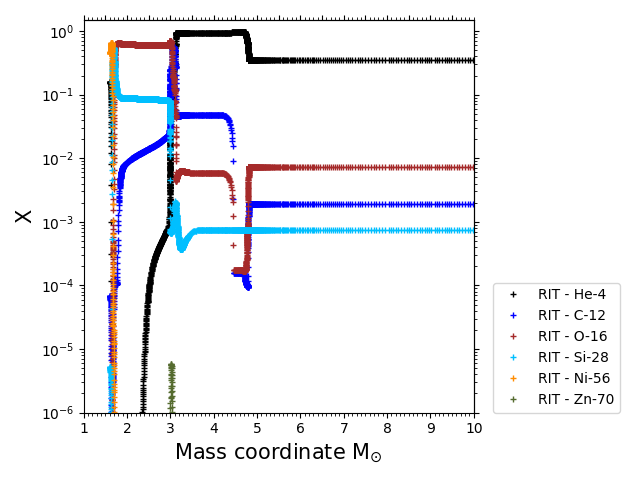

In [41]:
# abundance plot (Gabor 1) MP: why this figure is taking so long to be made?
# what is happening if I select more than one?

plt.clf()
fig, ax = plt.subplots()

ind_tmp = np.where(t9_cyc > 1.1e-9)[0][0]

plot_a()

masscut = min(mass[ind_tmp],mass_inc[0])
masscut = min(masscut,min(mass_sie[:]))

ax.set_xlim(1,10)
ax2=ax.secondary_xaxis('top')
ax2.set_xticks(np.arange(1, 10, 0.5))
ax2.set_xticklabels([])
ax.xaxis.set_minor_locator(plt.MultipleLocator(0.1))
ax2.xaxis.set_minor_locator(plt.MultipleLocator(0.1))
ax.set_xlabel(xlabel1,fontsize=15)

ax.set_ylim(1e-6,1.5)
ax3=ax.secondary_yaxis('right')
ax3.set_yticklabels([])
ax.set_ylabel(ylabel1,fontsize=15)

ax.legend(bbox_to_anchor=(1.05, 0), loc="lower left", borderaxespad=0)
plt.tight_layout() 

if abu_name != "":
    plt.savefig(abu_name, bbox_inches='tight', pad_inches=0.1,dpi=300)

plt.show()

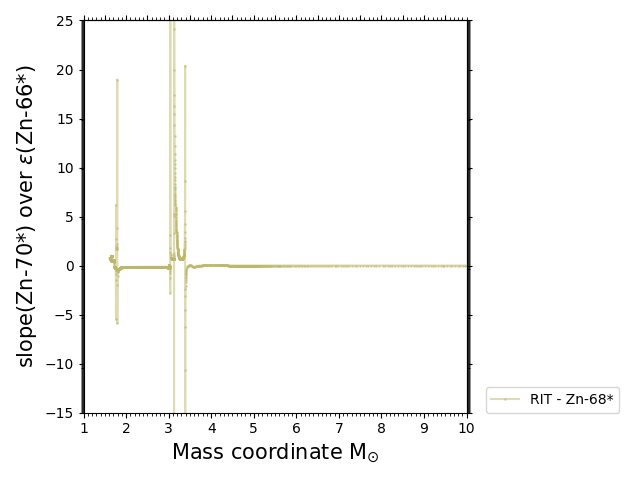

In [25]:
#Ratio plot (Gabor 2) MP: why this figure is taking so long to be made?
plt.clf()
fig, ax = plt.subplots()

ref_1 = mass_sie[np.argmax(sie_abund[e_label.index(iso_ref1)])]
  
plot_r()

masscut = min(mass[ind_tmp],mass_inc[0])
masscut = min(masscut,min(mass_sie[:]))

ax.set_xlim(1,10)
ax2=ax.secondary_xaxis('top')
ax2.set_xticks(np.arange(1, 10, 0.5))
ax2.set_xticklabels([])
ax.xaxis.set_minor_locator(plt.MultipleLocator(0.1))
ax2.xaxis.set_minor_locator(plt.MultipleLocator(0.1))
ax.set_xlabel(xlabel1,fontsize=15)

ax.set_ylim(-15,25)
ax3=ax.secondary_yaxis('right')
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
ax3.set_yticklabels([])
ax.set_ylabel(ylabel4,fontsize=15)
ax3.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
#ax.set_title("Ni-64*/Ni-61*")

ax.legend(bbox_to_anchor=(1.05, 0), loc="lower left", borderaxespad=0)
plt.tight_layout() 

if ratio1_name != "":
    plt.savefig(ratio1_name, bbox_inches='tight', pad_inches=0.1,dpi=300)

plt.show()


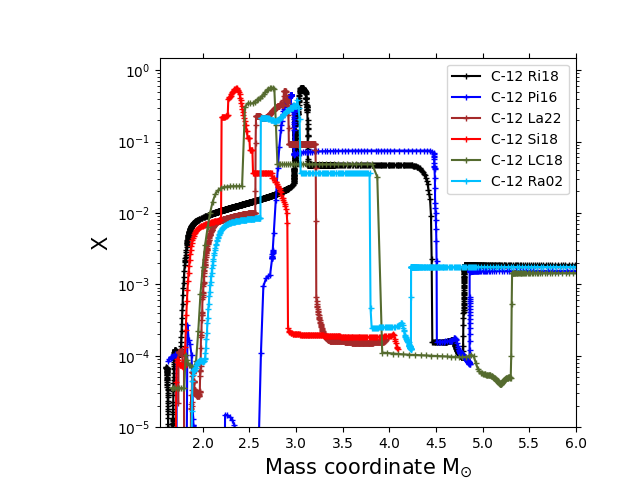

In [26]:
# abundance plot for selected isotopes; all together
ifig=24
plt.figure(ifig).clear(); plt.figure(ifig)

iso_selected = 'C-12'
ind_ = abu_isotopes.index(iso_selected)

for i in range(len(all_models)):
    plt.semilogy(all_models[label_models[i]][reqmass]['masscoord'],all_models[label_models[i]][reqmass]['abu'][iso_selected],color=col[i],marker=llin,markersize=4,ls='-',\
                 label=iso_selected + ' '+label_models[i])

plt.legend(loc='upper right')
masscut = min(min(all_models[label_models[i]][reqmass]['masscoord']) for i in range(len(all_models)))
plt.xlim(masscut,6); plt.ylim(1e-5,1.5)
plt.xlabel(xlabel1,fontsize=15); plt.ylabel(ylabel1,fontsize=15)
plt.tick_params(left=True,right=True,top=True,labelleft=True,which='both') #,labelright=True)

plt.gcf().subplots_adjust(left=0.25)    

plt.savefig('test'+iso_selected+'.pdf')
plt.show()


In [27]:
#print(slope_isotopes)

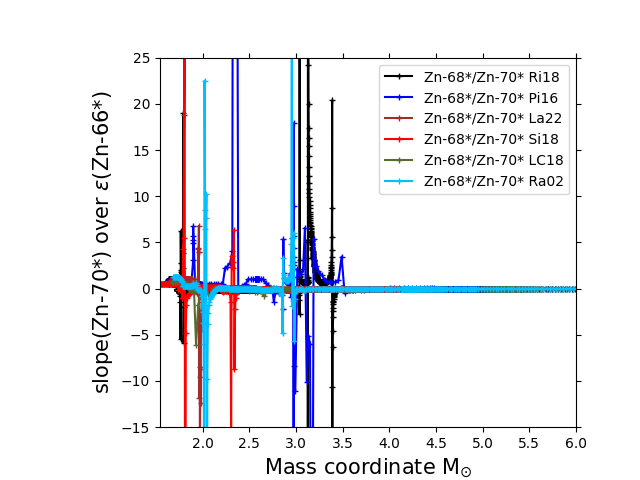

In [28]:
# slope plot for selected isotope; all together
ifig=25
plt.figure(ifig).clear(); plt.figure(ifig)

iso_selected = 'Zn-68*/Zn-70*'

for i in range(len(all_models)):
    plt.plot(all_models[label_models[i]][reqmass]['masscoord'],all_models[label_models[i]][reqmass]['slope'][iso_selected],color=col[i],marker=llin,markersize=4,ls='-',\
                 label=iso_selected + ' '+label_models[i])

plt.legend(loc='upper right')
masscut = min(min(all_models[label_models[i]][reqmass]['masscoord']) for i in range(len(all_models)))
plt.xlim(masscut,6) ; plt.ylim(-15,25)
plt.xlabel(xlabel1,fontsize=15); plt.ylabel(ylabel4,fontsize=15)
plt.tick_params(left=True,right=True,top=True,labelleft=True,which='both') #,labelright=True)

plt.gcf().subplots_adjust(left=0.25)    

#plt.savefig('test'+iso_selected+'.pdf')
plt.show()


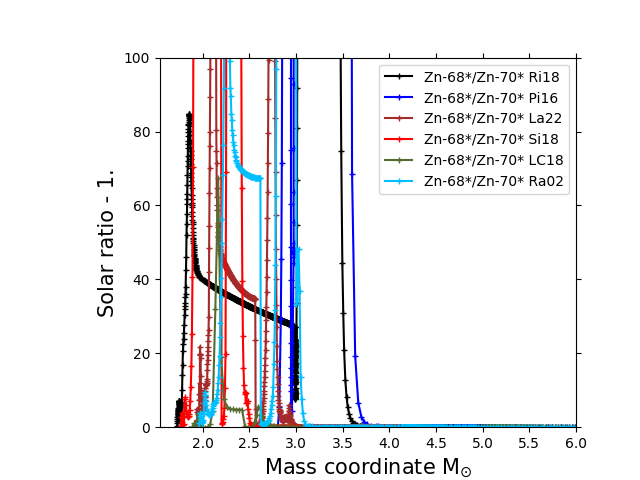

In [29]:
# slope plot for selected isotope; all together
ifig=26
plt.figure(ifig).clear(); plt.figure(ifig)

iso_selected = 'Zn-68*/Zn-70*'

for i in range(len(all_models)):
    plt.plot(all_models[label_models[i]][reqmass]['masscoord'],all_models[label_models[i]][reqmass]['isoratio_minus_1'][iso_selected],\
             color=col[i],marker=llin,markersize=4,ls='-',\
                 label=iso_selected + ' '+label_models[i])

plt.legend(loc='upper right')
masscut = min(min(all_models[label_models[i]][reqmass]['masscoord']) for i in range(len(all_models)))
plt.xlim(masscut,6) ; plt.ylim(0,100)
plt.xlabel(xlabel1,fontsize=15); plt.ylabel(ylabel2,fontsize=15)
plt.tick_params(left=True,right=True,top=True,labelleft=True,which='both') #,labelright=True)

plt.gcf().subplots_adjust(left=0.25)    

#plt.savefig('test'+iso_selected+'.pdf')
plt.show()


In [30]:
## abundance plot; Ritter
#ifig=11
#plt.figure(ifig).clear(); plt.figure(ifig)
#
## to plot abundances (ritter2018)
#
## index to skip what is not ejected
#ind_tmp = np.where(t9_cyc > 1.1e-9)[0][0]
##
#for i in plot_list:
#    plt.semilogy(mass[ind_tmp:],e_abund[i][ind_tmp:],color=col[i],marker=llin,\
#                 markersize=4,ls='',label=e_label[i])
#
#plt.legend(loc='lower right')
#masscut = min(mass[ind_tmp],mass_inc[0]) ; masscut = min(masscut,min(mass_sie[:]))
#plt.xlim(masscut,10); plt.ylim(1e-6,1.5)
#plt.xlabel(xlabel1,fontsize=15); plt.ylabel(ylabel1,fontsize=15)
#plt.tick_params(left=True,right=True,top=True,labelleft=True,which='both') #,labelright=True)
#
#plt.gcf().subplots_adjust(left=0.25)    
#
##plt.savefig('another_test.pdf')
#plt.show()

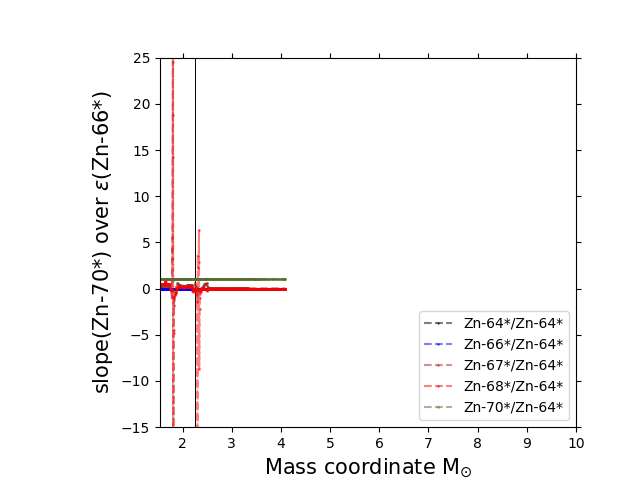

In [31]:
# ratio plot; Sieverdin
ifig=136
plt.figure(ifig).clear(); plt.figure(ifig)


# some ref? E.g., where Si28 has the max abundance
ref_1 = mass_sie[np.argmax(sie_abund[e_label.index(iso_ref1)])]
plt.axvline(x=ref_1,color='k',lw=0.7)
# or where Si29>Si30
#ref_2 = np.where(sie_abund[e_label.index('Si-29')] > sie_abund[e_label.index('Si-30')] )
#[list(group) for group in mit.consecutive_groups(list(ref_2))]
# [...]

# to plot Sieverdin data    
for i in range(len(iso_up_plot)):
    plt.plot(mass_sie[:],sie_slope[i],color=col[i],marker=lllin,ls='--',markersize=0.8,\
                 alpha=0.5,label=iso_up_plot[i]+'/'+iso_down_plot[i])
    
    

plt.legend(loc='lower right')
masscut = min(mass[ind_tmp],mass_inc[0]) ; masscut = min(masscut,min(mass_sie[:]))
plt.xlim(masscut,10) ; plt.ylim(-15,25)
plt.xlabel(xlabel1,fontsize=15); plt.ylabel(ylabel4,fontsize=15)
plt.tick_params(left=True,right=True,top=True,labelleft=True,which='both') #,labelright=True)

plt.gcf().subplots_adjust(left=0.25)    

plt.show()

In [32]:
#new_list = ['Ni-58','Ni-61', 'Ni-62', 'Ni-64','Ni-64*']
new_list = ['Zn-64','Zn-66', 'Zn-68', 'Zn-68*','Zn-70*']
ind_mass = np.where(np.array(rau_mass_1)>4.2)[0][0]
ind_iso = [e_label.index(i) for i in new_list]
print('mass=',str('%.2e' % rau_mass_1[ind_mass]),'Msun')
print(new_list)
print([rau_y[i][ind_mass] for i in ind_iso])

mass= 4.20e+00 Msun
['Zn-64', 'Zn-66', 'Zn-68', 'Zn-68*', 'Zn-70*']
[9.92376e-07, 5.87696e-07, 4.05939e-07, 4.0593921609121953e-07, 5.661563168060228e-08]


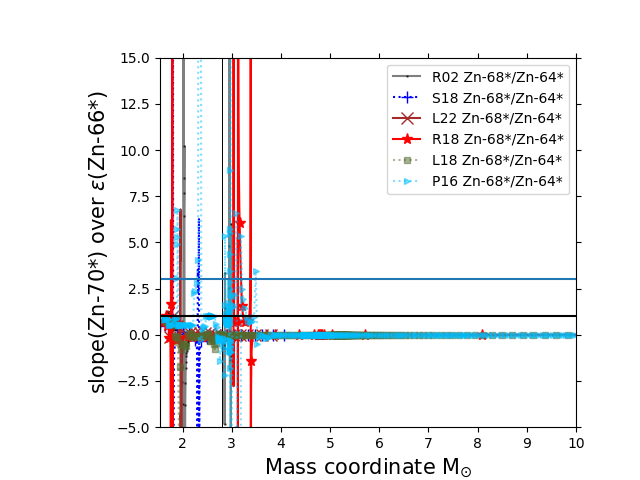

In [33]:
# ratio plot; Rauscher
ifig=87
plt.figure(ifig).clear(); plt.figure(ifig)


# some ref? E.g., where Si28 has the max abundance
ref_1 = rau_mass_1[np.argmax(rau_y[e_label.index(iso_ref1)])]
plt.axvline(x=ref_1,color='k',lw=0.7)
# or where Si29>Si30
#ref_2 = np.where(sie_abund[e_label.index('Si-29')] > sie_abund[e_label.index('Si-30')] )
#[list(group) for group in mit.consecutive_groups(list(ref_2))]
# [...]

# to plot stellar data    
#for i in range(len(iso_up_plot)):
#for i in [1,4]:
#for i in [4]:
#    plt.plot(rau_mass_1,rau_slope[i],color=col[0],marker=lllin,ls='-',markersize=0.8,\
#                 alpha=0.5,label=iso_up_plot[i]+'/'+iso_down_plot[i])
#    plt.plot(mass_sie[:],sie_slope[i],color=col[1],marker='+',ls=':',markersize=8,\
#                 alpha=1,markevery=20,label=iso_up_plot[i]+'/'+iso_down_plot[i])
#    plt.plot(mass_inc,law_slope[i],color=col[2],marker='x',ls='-',markersize=8,\
#                 alpha=1,markevery=50,label=iso_up_plot[i]+'/'+iso_down_plot[i])
#    plt.plot(mass[ind_tmp:],rit_slope[i][ind_tmp:],color=col[3],marker='*',ls='-',markersize=8,\
#                 alpha=1,markevery=50,label=iso_up_plot[i]+'/'+iso_down_plot[i])

#i = iso_up_plot.index('Ni-64*')
i = iso_up_plot.index('Zn-68*')

plt.plot(rau_mass_1,rau_slope[i],color=col[0],marker=lllin,ls='-',markersize=0.8,\
                 alpha=0.5,label='R02 '+iso_up_plot[i]+'/'+iso_down_plot[i])
plt.plot(mass_sie[:],sie_slope[i],color=col[1],marker='+',ls=':',markersize=8,\
         alpha=1,markevery=20,label='S18 '+iso_up_plot[i]+'/'+iso_down_plot[i])
plt.plot(mass_inc,law_slope[i],color=col[2],marker='x',ls='-',markersize=8,\
                 alpha=1,markevery=50,label='L22 '+iso_up_plot[i]+'/'+iso_down_plot[i])
plt.plot(mass[ind_tmp:],rit_slope[i][ind_tmp:],color=col[3],marker='*',ls='-',markersize=8,\
                 alpha=1,markevery=50,label='R18 '+iso_up_plot[i]+'/'+iso_down_plot[i])
plt.plot(lc18_mass_1,lc18_slope[i],color=col[4],marker=lllin,ls=':',markersize=4,\
                 alpha=0.5,label='L18 '+iso_up_plot[i]+'/'+iso_down_plot[i])
plt.plot(p16_mass[p16_ind_tmp:],p16_slope[i][p16_ind_tmp:],color=col[5],marker='>',ls=':',markersize=4,\
                 alpha=0.5,label='P16 '+iso_up_plot[i]+'/'+iso_down_plot[i])

    
plt.axhline(y=3)    
plt.axhline(y=1,ls='-',color='k')    

plt.legend(loc='upper right')
masscut = min(mass[ind_tmp],mass_inc[0]) ; masscut = min(masscut,min(mass_sie[:]))
plt.xlim(masscut,10) ; plt.ylim(-5,15)
plt.xlabel(xlabel1,fontsize=15); plt.ylabel(ylabel4,fontsize=15)
plt.tick_params(left=True,right=True,top=True,labelleft=True,which='both') #,labelright=True)

plt.gcf().subplots_adjust(left=0.25)    

plt.savefig('tmp.pdf')

plt.show()

In [34]:
#print('rit',rit_slope[-1])

In [35]:
#print(iso_up_plot)
#print('law',np.transpose(law_slope)[-1])
#print('rit',np.transpose(rit_slope)[-1])
#print('rau',np.transpose(rau_slope)[-1])
#print('pgn',np.transpose(p16_slope)[-1])
#print('lim',np.transpose(lc18_slope)[-1])
#print('sie',np.transpose(sie_slope)[-1])
#

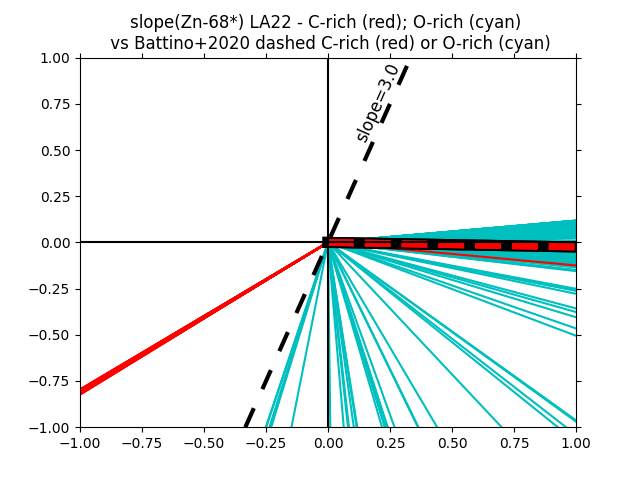

In [36]:
# ratio plot; slopes
ifig=76
plt.figure(ifig).clear(); plt.figure(ifig)

#iso_plot = 'Ni-64*'; iso_ref = 'Ni-61'
iso_plot = 'Zn-68*'; iso_ref = 'Zn-66'
ind_ = iso_up_plot.index(iso_plot)
indu_ = e_label.index(iso_plot); indd_ = e_label.index(iso_ref) 
indn_ = e_label.index(iso_norm_mu_and_eps[0]) ; inds_ = e_label.index(iso_norm_slope) 

ind_c12 = e_label.index("C-12"); ind_o16 = e_label.index("O-16")

# check kind of production factor of lim_relevance, otherwise do not show slope
lim_relevance = 5e0

#what_slope = rau_slope; what_abu = rau_y; surf_ind = -1
#what_slope = sie_slope; what_abu = sie_abund; surf_ind = -1 
#what_slope = rit_slope; what_abu = e_abund; surf_ind = -1
what_slope = law_slope; what_abu = y; what_mind = law_mind_slope; surf_ind = -1  
#what_slope = lc18_slope; what_abu = lc18_y; surf_ind = -1  
#what_slope = p16_slope; what_abu = p16_abund; surf_ind = -1

# get the sign for y and x. The sign for y is given by what_mind, the sign for x is given by the sign(what_mind)*sign(what_slope)
sign_x = np.sign(what_mind); sign_y = sign_x * np.sign(what_slope[ind_])


[plt.plot([0.,1.*sign_x[i]],[0.,1.*np.abs(what_slope[ind_][i])*sign_y[i]], ls='-', c='c') for i in range(len(what_slope[ind_])) if\
    what_abu[ind_][i] > lim_relevance * what_abu[ind_][surf_ind] or \
    what_abu[indd_][i] > lim_relevance *  what_abu[indd_][surf_ind] or \
    what_abu[indn_][i] > lim_relevance *  what_abu[indn_][surf_ind] or \
    what_abu[inds_][i] > lim_relevance *  what_abu[inds_][surf_ind] \
    if what_abu[ind_c12][i]/what_abu[ind_o16][i]<1]
[plt.plot([0.,1.*sign_x[i]],[0.,1.*np.abs(what_slope[ind_][i])*sign_y[i]], ls='-', c='r') for i in range(len(what_slope[ind_])) if\
    what_abu[ind_][i] > lim_relevance *  what_abu[ind_][surf_ind] or \
    what_abu[indd_][i] > lim_relevance *  what_abu[indd_][surf_ind] or \
    what_abu[indn_][i] > lim_relevance *  what_abu[indn_][surf_ind] or \
    what_abu[inds_][i] > lim_relevance *  what_abu[inds_][surf_ind] \
    if what_abu[ind_c12][i]/what_abu[ind_o16][i]>1]

# add comparison - AGB - crazy here since I have only one final snapshot
# note that here below I cannot use surface abundances as indicative anymore....
# well, this is not safe to do either for CCSNe with WR progenitors, Novae, etc. So, all of this will need to
# changed, and use solar as reference or solar scaled.
#what_slope = np.transpose(np.concatenate(([bat_slope], [bat_slope]), axis=0))
#what_abu = np.transpose(np.concatenate(([agb_abund], [agb_abund]), axis=0)) 
what_slope = bat_slope
what_abu = agb_abund
what_mind = bat_mind_slope
surf_ind = -1        

# get the sign for y and x. The sign for y is given by what_mind, the sign for x is given by the sign(what_mind)*sign(what_slope)
sign_x = np.sign(what_mind); sign_y = sign_x * np.sign(what_slope[ind_])

[plt.plot([0.,1.*sign_x[i]],[0.,1.*np.abs(what_slope[ind_][i])*sign_y[i]], c='k',ls='-',lw=8)  for i in range(len(what_slope[ind_])) if\
    what_abu[ind_c12][i]/what_abu[ind_o16][i]<1]
[plt.plot([0.,1.*sign_x[i]],[0.,1.*np.abs(what_slope[ind_][i])*sign_y[i]], c='k',ls='-',lw=8)  for i in range(len(what_slope[ind_])) if\
    what_abu[ind_c12][i]/what_abu[ind_o16][i]>1]
[plt.plot([0.,1.*sign_x[i]],[0.,1.*np.abs(what_slope[ind_][i])*sign_y[i]], c='c',ls='--',lw=5)  for i in range(len(what_slope[ind_])) if\
    what_abu[ind_c12][i]/what_abu[ind_o16][i]<1]
[plt.plot([0.,1.*sign_x[i]],[0.,1.*np.abs(what_slope[ind_][i])*sign_y[i]], c='r',ls='--',lw=5)  for i in range(len(what_slope[ind_])) if\
    what_abu[ind_c12][i]/what_abu[ind_o16][i]>1]

plt.axhline(y=0,color='k'); plt.axvline(x=0,color='k')

# slope from obs?
sl = 3.0
plt.axline((0, 0.0), slope=sl, color="black", linestyle=(0, (5, 5)), lw=3)
plt.text(0.1, 0.55, "slope="+str(sl), rotation=66, fontsize=12)

plt.title('slope('+iso_plot+\
          ') LA22 - C-rich (red); O-rich (cyan) \n vs Battino+2020 dashed C-rich (red) or O-rich (cyan)')
#plt.title('slope('+iso_plot+\
#          ') SI18 - C-rich (red); O-rich (cyan) \n vs Battino+2020 dashed C-rich (red) or O-rich (cyan)')

plt.xlim(-1,1); plt.ylim(-1,1)
plt.tick_params(left=True,right=True,top=True,labelleft=True,which='both') #,labelright=True)


plt.savefig('la22_vs_bat20'+iso_plot+'slope.pdf')

plt.show()


# Multi-level rose diagram

under development, it works just fine with python3.9.13 but it does not work with python3.6.9 (layout issue -- easy to solve --, handling of colormaps -- tricky)

In [37]:
#def as1darray(*a, dtype=np.float64):
#    size = None
#    
#    out = [np.asarray(x, dtype=dtype) if x is not None else x for x in a]
#    
#    for o in out:
#        if o is None:
#            continue
#        if o.ndim == 1 and o.size != 1:
#            if size is None:
#                size = o.size
#            elif o.size != size:
#                raise ValueError('Size of arrays do not match')
#        elif o.ndim > 1:
#            raise ValueError('array cannot have more than 1 dimension')
#    
#    out = tuple(o if (o is None or (o.ndim == 1 and o.size != 1)) else np.full(size or 1, o) for o in out)
#    if len(out) == 1:
#        return out[0]
#    else:
#        return out
#
## TODO xlabel, ylabel, weight_label
## TODO figure out how to plot legend for the histograms. Seperate subfigure?
## This how to deal with this in a subplot?
## constrained layout messes with putting figure labels on subfigure
#class MLR:
#    """
#    Multi-level rose diagram where you can plot data/histograms of directional data on concentric circles.
#
#    Parameters
#    ----------
#    xylim : (float, float)
#        A tuple containing a value that represents the positive, and negative extent, of the x and y axes.    
#    xylabels :(str, str)
#        A tuple containing the labels for the x and y axes. 
#    segment : {'N', 'S', 'E', 'W', 'All'}
#        Can be used to only show a segment of the full circle. Default is ``'All'``.
#    xylabel_pos : {'N', 'S', 'E', 'W', None}
#        The position of the x and y labels. Default position depends on the label.
#    cmap : str
#        The colour map to the be used. If no color map is given then ``'turbo'`` will be used but no legend will be shown.
#        See [matplotlib](https://matplotlib.org/stable/users/explain/colors/colormaps.html) docs for a list of avaliable 
#        colour maps.
#    cmap_vmin : float
#        The lower limit of the color map range. Default to 0 or, if ``cmap_log`` is ``True``, 1E-10.
#    cmap_vmax : float
#        The upper limit of the colour map range. If no value is given then the default is 1 and the data will be
#        normalised against the largest value when ``histxy`` or ``histm`` is called. If a value is given then the data will
#        not be normalised (even if that value is 1).
#    cmap_log : bool
#        If ``True`` a the colour map will use a log scale. Defaults to ``False``.
#    cmap_label : str
#        The label for the colour map legend.
#    """
#
#    # Made by Mattias Ek & Chiara Incollingo
#    def __init__(self, xylim = (1.0, 1.0), xylabels = (None, None), segment='All', xylabel_pos = None,
#                 cmap = None, cmap_vmin=None, cmap_vmax = None, cmap_log = False, cmap_label = None):
#        self.ylim = np.abs(xylim[0])
#        self.xlim = np.abs(xylim[1])
#        self.xscale = 1/np.abs(self.xlim)
#        self.yscale = 1/np.abs(self.ylim)
#        self.mscale = self.yscale/self.xscale
#        
#        #Create figure
#        self.figure, self.axes = plt.subplots(subplot_kw={'projection': 'polar'}, layout="constrained")
#        self.axes.set_theta_zero_location('N')
#        self.axes.set_theta_direction(-1)
#        #self.axes.set_thetagrids((np.pi*0, np.pi*0.5, np.pi*1, np.pi*1.5), (self.xscale, self.yscale, self.xscale*-1, self.yscale*-1))
#        self.axes.set_thetagrids((0, 90, 180, 270), (self.yscale, self.xscale, self.yscale*-1, self.xscale*-1))
#        
#        if cmap_vmax is None:
#            self.cmap_common_vmax = False
#            self.cmap_vmax = 1
#        else:
#            self.cmap_common_vmax = True
#            self.cmap_vmax = cmap_vmax
#            
#        if cmap_log:
#            self.cmap_vmin = 1E-10 if cmap_vmin is None else cmap_vmin
#            self.cmap_normalizer = mpl.colors.LogNorm(self.cmap_vmin, self.cmap_vmax)
#            
#        else:
#            self.cmap_vmin = 0 if cmap_vmin is None else cmap_vmin
#            self.cmap_normalizer = mpl.colors.Normalize(self.cmap_vmin, self.cmap_vmax)    
#        
#        if cmap:
#            self.cmap = mpl.colormaps['turbo' if cmap is True else cmap]
#            self.figure.colorbar(mpl.cm.ScalarMappable(self.cmap_normalizer, self.cmap), ax=self.axes)
#            
#        else:
#            self.cmap = mpl.colormaps['turbo']
#        
#        if segment.upper() == 'N':
#            self.axes.set_thetalim(-np.pi*0.5, np.pi*0.5)
#            self.axes.set_thetagrids((-90, 0, 90), (-self.xscale, self.yscale, self.xscale))
#        elif segment.upper() == 'S':
#            self.axes.set_thetalim((np.pi*0.5, np.pi*1.5))
#            self.axes.set_thetagrids((90, 180, 270), (-self.xscale, -self.yscale, self.xscale))
#        elif segment.upper() == 'E':
#            self.axes.set_thetalim(0, np.pi)
#            self.axes.set_thetagrids((0, 90, 180), (self.yscale, self.xscale, -self.yscale))
#        elif segment.upper() == 'W':
#            self.axes.set_thetalim(np.pi, np.pi*2)
#            self.axes.set_thetagrids((180, 270, 360), (-self.yscale, -self.xscale, self.yscale))
#        else:
#            self.axes.set_thetagrids((0, 90, 180, 270), (self.yscale, self.xscale, self.yscale*-1, self.xscale*-1))
#        
#        self.axes.set_yticklabels([])
#        # TODO set theta labels to correspont do scale
#        # Use N, NE etc to select only a segment of the plot
#    
#    def point2rad(self, x, y):
#        """
#        Convert the point ``x, y`` into an angle, in radians, within the space defined by the
#        objects ``xlim`` and ``ylim`` limits.
#        """
#        x, y = as1darray(x, y)
#        return np.array([self._point2rad_(x[i]*self.xscale, y[i]*self.yscale) for i in range(x.size)])
#    
#    @staticmethod
#    def _point2rad_(x, y):
#        """
#        Convert ``x, y`` to a angle in radians. Only accepts scalar values. 
#        """
#        if x == 0:
#            return np.pi/2
#        if y == 0:
#            return 0
#
#
#        if x > 0:
#            return np.pi * 0.5 - np.arctan(y/x)
#        else:
#            return np.pi * 1.5 - np.arctan(y/x)
#
#    def pointxy(self, x, y, r = 1, **kwargs):
#        """
#        Add a data point to the figure at radius ``r`` of the slope defined by the point (``x``, ``y``).
#        
#        Any additional keyword arguments will be passed onto matplotlibs 
#        [scatter](matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.scatter.html) function.
#        """
#        x, y = as1darray(x, y)
#        self.axes.scatter(self.point2rad(x,y), r, **kwargs)
#    
#    def pointxm(self, x, m, r = 1, merr= None, **kwargs):
#        """
#        Add a data point to the figure at radius ``r`` of the slope ``m`` at ``x``. 
#        
#        If the error of the slope, ``merr``, is given then a line will be drawn along ``r`` with the same
#        colour as the data point.
#        
#        Any additional keyword arguments will be passed onto matplotlibs 
#        [scatter](matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.scatter.html) function.
#        """
#        x, m, merr = as1darray(x, m, merr)
#        
#        point_lines = self.axes.scatter(self.point2rad(x, m*x), r, **kwargs)
#        
#        if merr:
#            rn = 100
#            theta = np.linspace(self.point2rad(x, (m-merr)*x), self.point2rad(x, (m+merr)*x), rn)
#            merr_lines = self.axes.plot(theta, np.full(rn, r), color = point_lines.get_facecolor(), zorder=0.99, marker="")
#    
#    # add x as optional and if given plot point
#    def slope(self, m, merr=None, merr_line = '--', merr_alpha = 0.2, rmax = None, **kwargs):
#        """
#        Draw a line if slope ``m`` on the figure.
#        
#        The line will be drawn within the current radius limit of the figure unless ``rmax`` is given.
#        
#        If ``merr``is is given the uncertiainty of the slope will be drawn using the ``merr_line`` linestyle and
#        the are between the lines shaded with an alpha value of ``merr_alpha``. You can disable either of these by
#        setting the value to ``False``.
#        
#        Any additional keyword arguments will be passed onto matplotlibs 
#        [plot](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.plot.html) function.
#        """
#        ax = self.axes
#        rmax = rmax or ax.get_rmax()
#        slope_kwargs = {'linestyle': '-', 'linewidth': 1}
#        slope_kwargs.update(kwargs)
#
#        slope_line = ax.plot(self.point2rad([1, -1], [m, m*-1]), [rmax, rmax], marker="", **slope_kwargs)[0]
#        if merr is not None:
#
#            if merr_line:
#                slope_kwargs = {'linestyle': merr_line, 'linewidth': 1, 'color': slope_line.get_color()}
#
#                ax.plot(self.point2rad([1, -1], [(m+merr), (m+merr)*-1]), [rmax, rmax], marker="", **slope_kwargs)
#                ax.plot(self.point2rad([1, -1], [(m-merr), (m-merr)*-1]), [rmax, rmax], marker="", **slope_kwargs)
#
#            if merr_alpha:
#                rn = 100
#                theta1 = np.linspace(self.point2rad(1, (m-merr)), self.point2rad(1, (m+merr)), rn)
#                theta2 = np.linspace(self.point2rad(-1, (m+merr)*-1), self.point2rad(-1, (m-merr)*-1), rn)
#                ax.fill(np.append(theta1, theta2), np.full(rn*2, rmax), alpha = merr_alpha, facecolor=slope_line.get_color())
#    
#    def histxy(self, x, y, r, weights=1, nbins=72, rwidth=0.9, rscale = 'rel', vmax = None, antipodal=False):
#        """
#        Create a circular histogram of the slope defined by the (``x``, ``y``) data point with ``weights``, starting at the radius ``r``. 
#        
#        The entire circle is divided into ``nbins`` segments of equal size. By default one segment every 5°. 
#        
#        The colour of each segment corresponds to the colour map range. If ``vmax`` is given then the bin weights are normalised to 
#        that value. If it is not specified and ``cmap_vmax'' is not specified then
#        the bin weights are normalised against the maximum bin weight.
#        
#        The colur of each segment is determiend by the bin weight relative to the colour map range.
#            - If ``rscale`` is ``"rel"`` then width of the maximum bin weight is set to ``rwidth``.
#            - if ``rscale`` is ``"abs"`` then the ``rwidth`` corresponds to the maximum value of the colour map range.
#            - If ``rscale`` is ``False`` then the width of each bin is equal to ``rwidth`` (Independent of bin weight).
#        
#        If ``antipodal`` is ``True`` the weight of point (``x``, ``y``) will also be added to its antipode.
#        """
#        x, y, weights = as1darray(x, y, weights)
#        
#        theta = self.point2rad(x, y)
#        if antipodal:
#            theta = np.append(theta, self.point2rad(-1, (y/x)*-1))
#            weights = np.append(weights, weights)
#        
#        bin_weights, bin_edges = np.histogram(theta, bins=nbins, range=(0, np.pi*2), weights=weights, density=False)
#        
#        if vmax is None:
#            if self.cmap_common_vmax is False:
#                vmax = np.max(bin_weights)
#            else:
#                vmax = self.cmap_vmax
#        
#        bin_weights = bin_weights / vmax
#            
#        if not rscale:
#            bin_widths = np.full(bin_weights.size, rwidth)
#        else:
#            bin_widths = np.array([self.cmap_normalizer(bw, clip=True) for bw in bin_weights])
#            if rscale == 'abs':
#                bin_widths = bin_widths * rwidth
#            elif rscale == 'rel':
#                bin_widths = (bin_widths*1/np.max(bin_widths))*rwidth
#                
#        bin_colors = np.array([self.cmap(self.cmap_normalizer(bw)) for bw in bin_weights])
#
#        for i in range(nbins):
#            rn = 100
#            edges = np.append(e:=np.linspace(bin_edges[i], bin_edges[i+1], rn), np.flip(e))
#            rs = np.append(np.full(rn, r), r + np.full(rn, bin_widths[i]))
#            
#            self.axes.fill(edges, rs, alpha = 1, facecolor=bin_colors[i])
#    
#    def histm(self, m, r, weights=1, bins=72, rwidth=0.9, rscale = 'rel', vmax=None):
#        """
#        Create a circular histogram of the slope defined by the ``m`` with ``weights``, starting at the radius ``r``.
#        
#        See ``histxy`` method for details of additional arguments.
#        """
#        m = as1darray(m)
#        return self.histxy(np.full(m.size, 1), m , r, weights, bins, rwidth, rscale, vmax, antipodal=True)
#    
#    def set_rlim(self, rmin, rmax):
#        """
#        Set the radius limits of the figure.
#        """
#        self.axes.set_rlim((rmin,rmax))

In [38]:
## Test case
#rng = np.random.default_rng()
#
#x = rng.normal(1,1, 1000)
#y = rng.normal(1,1, 1000)
#weights = rng.uniform(1,100, 1000)
#
#ax = MLR(cmap = 'turbo')
#ax.histxy(x, y, 1, 1)
#ax.histm(y/x, 2, 10)
#
#ax.pointxm(1,1, merr=0.5, r=4)
#ax.pointxm(1, -1, merr=0.5, r=2.9, edgecolor='black')
#
#ax.slope(1, merr=0.5)
#ax.slope(1.2, merr=0.1)
#ax.set_rlim(0,4.1)
#

In [39]:
## Each point in the model has the same weight
#ax = MLR(cmap = 'turbo', cmap_log = True, cmap_vmin=0.001)
#
#for j, name in enumerate(all_models.keys()):
#    ax.histm(all_models[name][reqmass]['slope']['Ni-64*/Ni-62*'], j+1)

In [40]:
## The weight of each point is equal to the sum of the abundance of all Ni isotopes
#ax = MLR(cmap = 'turbo', cmap_log = True, cmap_vmin=0.001)
#weight_isotopes = [iso for iso in abu_isotopes if (iso.startswith('Ni') and iso.endswith('*'))]
#print(weight_isotopes)
#
#for j, name in enumerate(all_models.keys()):
#    weight = np.sum([all_models[name][reqmass]['abu'][iso] for iso in weight_isotopes], axis=0)
#    
#    ax.histm(all_models[name][reqmass]['slope']['Ni-64*/Ni-62*'], j+1, weights = weight, vmax = np.sum(weight))#